### States and Believe States

In [1]:
from typing import NamedTuple, List
from enum import Enum

State = NamedTuple('State', [('row', int),  # in range [1, 3]
                             ('col', int)]) # in range [1, 4]
#interp. a state represented by grid location with row and columns (row, col)

Pillar = State(2, 2)       # state(2, 2) is a pillar in the graph and cannot be entered
Incinerator = State(2, 4)  # state(2, 4) is a bad terminal state
GoodEnding = State(3, 4)   # state(3, 4) is a good terminal state
S0 = State(0, 0)
S1 = State(3, 2)
S2 = State(1, 1)

# tempalte based on compound. (2 fields)
# def fn_for_State(s: State) -> ...:
#     return ...(b.row,      #int
#                b.col)      #int


BelieveState = float # in range [0, 1]
# interp. a percentage chance of being in a state

BS0 = 1 / 9
BS1 = 0

BelieveStateRow = List[BelieveState]
# interp. all believeStates in a row

BSR3 = [BS0, BS0, BS0, BS1]  # example of the bs row (for our grid world) initially in uniform distribution
BSR2 = [BS0, BS1, BS0, BS1]  # assumes the agent cannot be in either of the terminal states initially
BSR1 = [BS0, BS0, BS0, BS0]
#        1    2    3    4

BelieveStateMatrix = List[BelieveStateRow]
# interp. the full picture of the believeStates

UniformBSM = [BSR1, BSR2, BSR3]
BSM13 = [[0, 0, 1, 0], # 1   Note: for ease of computation the matrix will have the lowest row num at the
         [0, 0, 0, 0], # 2         beginning
         [0, 0, 0, 0]] # 3
# col     1  2  3  4

BSM11 = [[1, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]

ZeroMatrix = [[0, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 0]]

### Action and list of actions

In [2]:
Actions = Enum('Actions', ['up', 'down', 'left', 'right'])
# interp. an action that an agent can take (up, down, left, and right)

Up = Actions.up
Down = Actions.down
Left = Actions.left
Right = Actions.right

# template based on the One Of rule and the Atomic Distinct rule (4 times)
# def fn_for_actions(actions: Actions) -> ...: 
#     if (actions == Actions.up):
#         return ...
#     elif (actions == Actions.down):
#         return...
#     elif (actions == Actions.left):
#         return...
#     elif (actions == Actions.right):
#         return...


# List[Actions]
# interp. a list of actions
LA1 = [Up, Up, Up]
LA2 = [Right, Right, Up]
LA3 = [Up, Right, Right, Right]

### Observation and list of Observations

In [3]:
Observations = Enum("Observations", ["one", "two", "end"])
# interp. an observation of the agent in a state (one wall, two walls, end(terminal state))

One = Observations.one
Two = Observations.two
End = Observations.end

# template based on the One Of rule and the Atomic Distinct rule (4 times)
# def fn_for_observations(observations: Observations) -> ...:
#     if (observations == Observations.one):
#         return ...
#     elif (observations == Observations.two):
#         return ...
#     elif (observations == Observations.end):
#         return ...

# List[Observations]
# interp. a list of observations
LO1 = [Two, Two, Two]
LO2 = [One, One, One]
LO3 = [One, One, End]
LO4 = [Two, Two, One, One]

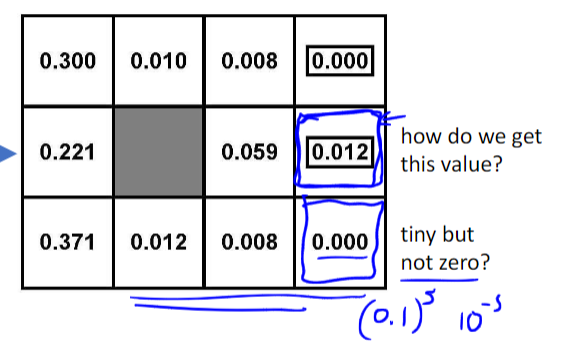

In [38]:
from typing import Optional
import numpy as np
    
def generate_ini_bsm(s: State) -> BelieveStateMatrix:
    """
    return a BSM where the specified state has a probability of 1 (the other states has a probability of 0)
    """
    result = [[0, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 0]]
    row = s.row - 1            # -1 to convert 1-based index to 0-based index
    col = s.col - 1
    result[row][col] = 1
    return result

def get_ini_bsm(ini: Optional[State]) -> BelieveStateMatrix:
    """
    Given a initialState and return the uniformBSM if ini is null, else return a BSM where the
    specified state has a probability of 1 (the other states has a probability of 0)
    The state cannot be the pillar (2, 2) or one of the terminal states (2, 4), (3, 4)
    """
    if (ini == None):
        return UniformBSM
    else:
        assert (ini != State(2, 2))
        assert (ini != State(2, 4))
        assert (ini != State(3, 4))
        return generate_ini_bsm(ini)
    

def convert_bsr_to_str(bsr: BelieveStateRow, i: int) -> str:
    """
    Given a BelieveStateRow and an row index (starting in 1), return the string representation of the bsr
    """
    bsrStr = str(i) + ' |'
    if (i != 2):
        for bs in bsr:
            bsrStr += (str(format(bs, '.3f')) + '|')
    else:
        for colIndex, bs in enumerate(bsr, start = 1):
            if (colIndex != 2):
                bsrStr += (str(format(bs, '.3f')) + '|')
            else:
                bsrStr += '-----|'
    bsrStr += '\n'
    
    return bsrStr
    

def convert_bsm_to_str(bsm: BelieveStateMatrix) -> str:
    """
    Given a belive state matrix, convert it to a string that represent this bsm
    """
    bsmStr = ''
    
    for i in range(3, 0, -1):
        bsmStr += convert_bsr_to_str(bsm[i - 1], i)
    
    bsmStr += '     1     2     3     4   \n'
    return bsmStr
    

def print_bsm(bsm: BelieveStateMatrix) -> None:
    """
    Given a bsm print it in the format:
    3 |0.300|0.010|0.008|0.000|
    2 |0.221|-----|0.059|0.012|
    1 |0.371|0.012|0.008|0.000|
         1     2     3     4  
    """
    print(convert_bsm_to_str(bsm))
        


def observation_probability(s: State, obs: Observations) -> float:
    """
    Given a state and an observation, return the probability of the observation in that state
    """
    assert (1 <= s.col <= 4)
    assert (1 <= s.row <= 3)
    assert (s != State(2, 2))
    
    if (s == State(2, 4) or s == State(3, 4)):
        if (obs == End):
            return 1
        else:
            return 0
    elif (s.col == 3):
        if (obs == One):
            return 0.9
        elif (obs == Two):
            return 0.1
        else:
            return 0
    else:
        if (obs == One):
            return 0.1
        elif (obs == Two):
            return 0.9
        else:
            return 0
        
        
def get_state_able_to_reach_state_prime(s: State, action: Actions) -> List[State]:
    """
    Given a statePrime and action, return all states able to reach statePrime with the action
    """
    assert (s != State(2, 2))
    # unfortunately had to hard code this
    if (action == Left):
        if   (s == State(1, 1)):
            return [State(1, 1), State(1, 2), State(2, 1)]
        elif (s == State(1, 2)):
            return [State(1, 2), State(1, 3)]
        elif (s == State(1, 3)):
            return [State(1, 3), State(1, 4), State(2, 3)]
        elif (s == State(1, 4)):
            return [State(1, 4)]
        elif (s == State(2, 1)):
            return [State(2, 1), State(1, 1), State(3, 1)]
        elif (s == State(2, 3)):
            return [State(2, 3), State(1, 3), State(3, 3)]
        elif (s == State(2, 4)):   # terminal
            return [State(2, 4), State(1, 4)]
        elif (s == State(3, 1)):
            return [State(3, 1), State(3, 2), State(2, 1)]
        elif (s == State(3, 2)):
            return [State(3, 2), State(3, 3)]
        elif (s == State(3, 3)):
            return [State(3, 3), State(2, 3)]
        elif (s == State(3, 4)):   # terminal
            return [State(3, 4)]
    elif (action == Right):
        if   (s == State(1, 1)):
            return [State(1, 1), State(2, 1)]
        elif (s == State(1, 2)):
            return [State(1, 2), State(1, 1)]
        elif (s == State(1, 3)):
            return [State(1, 3), State(1, 2), State(2, 3)]
        elif (s == State(1, 4)):
            return [State(1, 4), State(1, 3)]
        elif (s == State(2, 1)):
            return [State(2, 1), State(1, 1), State(3, 1)]
        elif (s == State(2, 3)):
            return [State(1, 3), State(3, 3)]
        elif (s == State(2, 4)):   # terminal
            return [State(2, 4), State(2, 3), State(1, 4)]
        elif (s == State(3, 1)):
            return [State(3, 1), State(2, 1)]
        elif (s == State(3, 2)):
            return [State(3, 2), State(3, 1)]
        elif (s == State(3, 3)):
            return [State(3, 3), State(2, 3)]
        elif (s == State(3, 4)):   # terminal
            return [State(3, 4), State(3, 3)]
    elif (action == Up):
        if   (s == State(1, 1)):
            return [State(1, 1), State(1, 2)]
        elif (s == State(1, 2)):
            return [State(1, 2), State(1, 1), State(1, 3)]
        elif (s == State(1, 3)):
            return [State(1, 2), State(1, 4)]
        elif (s == State(1, 4)):
            return [State(1, 4), State(1, 3)]
        elif (s == State(2, 1)):
            return [State(2, 1), State(1, 1)]
        elif (s == State(2, 3)):
            return [State(2, 3), State(1, 3)]
        elif (s == State(2, 4)):   # terminal
            return [State(2, 4), State(2, 3), State(1, 4)]
        elif (s == State(3, 1)):
            return [State(3, 1), State(3, 2), State(2, 1)]
        elif (s == State(3, 2)):
            return [State(3, 2), State(3, 1), State(3, 3)]
        elif (s == State(3, 3)):
            return [State(3, 3), State(3, 2)]
        elif (s == State(3, 4)):   # terminal
            return [State(3, 4), State(3, 3)]
    elif (action == Down):
        if   (s == State(1, 1)):
            return [State(1, 1), State(1, 2), State(2, 1)]
        elif (s == State(1, 2)):
            return [State(1, 2), State(1, 1), State(1, 3)]
        elif (s == State(1, 3)):
            return [State(1, 3), State(1, 2), State(1, 4), State(2, 3)]
        elif (s == State(1, 4)):
            return [State(1, 4), State(1, 3)]
        elif (s == State(2, 1)):
            return [State(2, 1), State(3, 1)]
        elif (s == State(2, 3)):
            return [State(2, 3), State(3, 3)]
        elif (s == State(2, 4)):   # terminal
            return [State(2, 4), State(2, 3)]
        elif (s == State(3, 1)):
            return [State(3, 1), State(3, 2)]
        elif (s == State(3, 2)):
            return [State(3, 2), State(3, 1), State(3, 3)]
        elif (s == State(3, 3)):
            return [State(3, 2)]
        elif (s == State(3, 4)):   # terminal
            return [State(3, 4)]
        

def get_transition_probability(statePrime: State, s: State, action: Actions) -> float:
    """
    given a statePrime, a state capable of reaching the statePrime, and an action, return the probability
    of state s reaching statePrime via the action
    
    Assumes statePrime and state are near each other
    """
    assert(statePrime != State(2, 2))
    assert(s != State(2, 2))
    if (s == State(2, 4) or s == State(3, 4)):
        if (statePrime == s):
            return 1
        else:
            return 0  
    elif (action == Left):
        if (statePrime.col < s.col):
            return 0.8
        elif (statePrime.col == s.col):
            if ((s.col - 1 <= 0 and s.row - 1 <= 0) or (s.col - 1 <= 0 and s.row + 1 >= 4)):
                return 0.9
            elif (statePrime == s):
                if (s == State(1, 2) or s == State(3, 2)):
                    return 0.2
                else:
                    return 0.8
            else:
                return 0.1
        else:
            return 0
    elif (action == Right):
        if (statePrime.col > s.col):
            return 0.8
        elif (statePrime.col == s.col):
            if ((s.col + 1 >= 5 and s.row - 1 <= 0) or (s.col + 1 >= 5 and s.row + 1 >= 4)):
                return 0.9
            elif (statePrime == s):
                if (s == State(1, 2) or s == State(3, 2)):
                    return 0.2
                else:
                    return 0.8
            else:
                return 0.1
        else:
            return 0
    elif (action == Up):
        if (statePrime.row > s.row):
            return 0.8
        elif (statePrime.row == s.row):
            if ((s.row + 1 >= 4 and s.col - 1 <= 0) or (s.row + 1 >= 4 and s.col + 1 >= 5)):
                return 0.9
            elif (statePrime == s):
                if (s == State(2, 1)):
                    return 0.2
                else:
                    return 0.8
            else:
                return 0.1
        else: 
            return 0
    else: # action == Down
        if (statePrime.row < s.row):
            return 0.8
        elif (statePrime.row == s.row):
            if ((s.row - 1 <= 0 and s.col - 1 <= 0) or (s.row - 1 <= 0 and s.col + 1 >= 5)):
                return 0.9
            elif (statePrime == s):
                if (s == State(2,1)):
                    return 0.2
                else:
                    return 0.8
            else: 
                return 0.1
        else:
            return 0
    

def compute_next_bs(bsm: BelieveStateMatrix, statePrime: State, observation: Observations, action: Actions) -> float:
    """
    Given a bsm, statePrime, observation, and action, return the computed value of stateprime s'
    """
    obsProbability = observation_probability(statePrime, observation)                     # float
    statesAbleToReachStatePrime = get_state_able_to_reach_state_prime(statePrime, action) # los
    
    theSum = 0
    
    print(statePrime)
    
    for s in statesAbleToReachStatePrime:
        print("Prev Believe In State " + str(s.row) + ", " + str(s.col) + " is " + str(bsm[s.row - 1][s.col - 1]))
        believeValInState = bsm[s.row - 1][s.col - 1] # TODO, something wrong here
        transitionProbability = get_transition_probability(statePrime, s, action)
        print("TransProb is " + str(transitionProbability))
        theSum += (transitionProbability * believeValInState)
        print("The Sum + TransProb * believeValInState = " + str(theSum))
        
    result = obsProbability * theSum
    print("Gets " + str(result))
    return result



def apply_normalization(bsm: BelieveStateMatrix) -> BelieveStateMatrix:
    """
    Given bsm, the sum, make it so that the bsm sums up to 1, and return it
    """
    nonZeroCount = 0
    theSum = 0
    for bsr in bsm:
        for bs in bsr:
            if (bs != 0):
                theSum += bs
                nonZeroCount += 1
    
    normalizationFactor = (1 / nonZeroCount) / (theSum / nonZeroCount)
    
    newBSM = [[],[],[]]
    
    for i, bsr in enumerate(bsm):
        for j, bs in enumerate(bsr):
            if (bs != 0):
                newBSM[i].append(bs * normalizationFactor)
            else:
                newBSM[i].append(0)
            
    return newBSM
        

def update_bsm(bsm: BelieveStateMatrix, action: Actions, observation: Observations) -> BelieveStateMatrix:
    """
    Given a bsm b(s), action, and an observation, compute and return the next bsm b'(s')
    """
    result = [[0, 0, 0, 0],[0, 0, 0, 0],[0, 0, 0, 0]]
    
    for rowIndex, bsr in enumerate(bsm, start = 1):
            for colIndex, bs in enumerate(bsr, start = 1):
                # update the bs for each state
                statePrime = State(rowIndex, colIndex)
                #print(statePrime)
                if (statePrime != State(2, 2)):
                    nextBsVal = compute_next_bs(bsm, statePrime, observation, action)
                    #print("Gets " + str(nextBsVal))
                    result[rowIndex - 1][colIndex - 1] = nextBsVal
                
    # make sure the matrix sums up to 1
    return apply_normalization(result)

    

def map_believe_state(ini: Optional[State], loa: List[Actions], loo: List[Observations]) -> None:
    """
    Given input
    • an initial state s
    • a sequence of actions a1:n
    • a sequence of observations e1:n
    computes and prints out the belief state of the agent after performing a1:n 
    and observing e1:n (i.e., observing each ei after performing the corresponding ai ).
    """
    assert (len(loa) == len(loo))
    believe_state_matrix = get_ini_bsm(ini)
    for i in range(0, len(loa)):
        action = loa[i]
        observation = loo[i]
        believe_state_matrix = update_bsm(believe_state_matrix, action, observation)
        
    print_bsm(believe_state_matrix)

In [39]:
import unittest

class TestStringMethods(unittest.TestCase):

    def test_generate_ini_bsm(self):
        self.assertEqual(generate_ini_bsm(State(2,3)), [[0, 0, 0, 0],
                                                        [0, 0, 1, 0],
                                                        [0, 0, 0, 0]])
        self.assertEqual(generate_ini_bsm(State(1,4)), [[0, 0, 0, 1],
                                                        [0, 0, 0, 0],
                                                        [0, 0, 0, 0]])
        self.assertEqual(generate_ini_bsm(State(1,3)), BSM13)
    
    
    def test_get_ini_bsm(self):
        self.assertEqual(get_ini_bsm(None), UniformBSM)
        self.assertEqual(get_ini_bsm(State(1,3)), BSM13)
        
        with self.assertRaises(Exception) as context:
            get_ini_bsm(State(2,2))
            get_ini_bsm(State(2,4))
            get_ini_bsm(State(3,4))
        
    
    def test_convert_bsr_to_str(self):
        self.assertEqual(convert_bsr_to_str([0.11345, 0.4448442, 0.1592652, 0], 1), '1 |0.113|0.445|0.159|0.000|\n')
        self.assertEqual(convert_bsr_to_str([0.1, 0.4448442, 0.1592652, 0.32], 3), '3 |0.100|0.445|0.159|0.320|\n')
        self.assertEqual(convert_bsr_to_str([0.1, 0.2, 0.5, 0.2], 2), '2 |0.100|-----|0.500|0.200|\n')
        
    
    def test_convert_bsm_to_str(self):
        firstRow  = '3 |0.100|0.445|0.159|0.320|\n'
        secondRow = '2 |0.100|-----|0.500|0.200|\n'
        thirdRow  = '1 |0.113|0.445|0.159|0.000|\n'
        colIndex  = '     1     2     3     4   \n'
        expectStr1 = firstRow + secondRow + thirdRow + colIndex
        self.assertEqual(convert_bsm_to_str([[0.11345, 0.4448442, 0.1592652, 0   ],
                                             [0.1    , 0.2      , 0.5      , 0.2 ],
                                             [0.1    , 0.4448442, 0.1592652, 0.32]]), expectStr1)
        
    def test_observation_probability(self):
        self.assertEqual(observation_probability(State(2, 4), One), 0)
        self.assertEqual(observation_probability(State(2, 4), End), 1)
        self.assertEqual(observation_probability(State(3, 4), Two), 0)
        self.assertEqual(observation_probability(State(3, 4), End), 1)
        self.assertEqual(observation_probability(State(1, 4), Two), 0.9)
        self.assertEqual(observation_probability(State(2, 1), One), 0.1)
        self.assertEqual(observation_probability(State(3, 3), Two), 0.1)
        self.assertEqual(observation_probability(State(1, 3), One), 0.9)
        with self.assertRaises(Exception) as context:
            observation_probability(State(2,2), One)
            observation_probability(State(2,9), Two)
            observation_probability(State(6,4), End)
        
        
    def test_get_state_able_to_reach_state_prime(self):
        self.assertCountEqual(get_state_able_to_reach_state_prime(State(1, 1), Left), [State(1, 1),
                                                                                       State(2, 1),
                                                                                       State(1, 2)])
        self.assertCountEqual(get_state_able_to_reach_state_prime(State(3, 3), Down), [State(3, 2)])
        
        
    
    def test_get_transition_probability(self):
        self.assertEqual(get_transition_probability(State(1, 1), State(1, 2), Down),  0.1)
        self.assertEqual(get_transition_probability(State(1, 1), State(2, 1), Down),  0.8)
        self.assertEqual(get_transition_probability(State(2, 1), State(2, 1), Down),  0.2)
        self.assertEqual(get_transition_probability(State(1, 1), State(1, 1), Down),  0.9)
        self.assertEqual(get_transition_probability(State(1, 4), State(1, 4), Down),  0.9)
        self.assertEqual(get_transition_probability(State(2, 1), State(2, 1), Up),    0.2)
        self.assertEqual(get_transition_probability(State(3, 1), State(2, 1), Up),    0.8)
        self.assertEqual(get_transition_probability(State(3, 1), State(3, 1), Up),    0.9)
        self.assertEqual(get_transition_probability(State(3, 1), State(3, 2), Up),    0.1)
        self.assertEqual(get_transition_probability(State(3, 4), State(3, 3), Up),    0.1)
        self.assertEqual(get_transition_probability(State(3, 4), State(3, 4), Up),    1)
        self.assertEqual(get_transition_probability(State(2, 3), State(2, 4), Up),    0)
        self.assertEqual(get_transition_probability(State(1, 2), State(1, 2), Right), 0.2)
        self.assertEqual(get_transition_probability(State(1, 4), State(1, 4), Right), 0.9)
        self.assertEqual(get_transition_probability(State(1, 4), State(1, 3), Right), 0.8)
        self.assertEqual(get_transition_probability(State(2, 1), State(2, 1), Right), 0.8)
        self.assertEqual(get_transition_probability(State(3, 2), State(3, 2), Right), 0.2)
        self.assertEqual(get_transition_probability(State(2, 3), State(3, 3), Right), 0.1)
        self.assertEqual(get_transition_probability(State(1, 1), State(1, 1), Left),  0.9)
        self.assertEqual(get_transition_probability(State(1, 1), State(2, 1), Left),  0.1)
        self.assertEqual(get_transition_probability(State(3, 3), State(2, 3), Left),  0.1)
        self.assertEqual(get_transition_probability(State(2, 1), State(2, 1), Left),  0.8)
        self.assertEqual(get_transition_probability(State(1, 3), State(1, 4), Left),  0.8)
        self.assertEqual(get_transition_probability(State(2, 3), State(2, 4), Left),  0)
        self.assertEqual(get_transition_probability(State(1, 2), State(1, 2), Left),  0.2)
        
        
    def test_compute_next_bs(self):
        self.assertEqual(compute_next_bs(BSM11, State(1, 1), Two, Left), 0.81)
        
        
        
    def test_apply_normalization(self):
        self.assertEqual(apply_normalization([[0, 0.1, 0, 0.4],
                                              [0, 0, 0.2, 0],
                                              [0, 0, 0, 0.2]]), [[0, 0.1 * (10 / 9), 0, 0.4 * (10 / 9)],
                                                                 [0, 0, 0.2 * (10 / 9), 0],
                                                                 [0, 0, 0, 0.2 * (10 / 9)]])
        
unittest.main(argv=[''], verbosity=1, exit=False)

.........

State(row=1, col=1)
Prev Believe In State 1, 1 is 1
TransProb is 0.9
The Sum + TransProb * believeValInState = 0.9
Prev Believe In State 1, 2 is 0
TransProb is 0.8
The Sum + TransProb * believeValInState = 0.9
Prev Believe In State 2, 1 is 0
TransProb is 0.1
The Sum + TransProb * believeValInState = 0.9
Gets 0.81



----------------------------------------------------------------------
Ran 9 tests in 0.009s

OK


In [40]:
A1 = [Up, Up, Up]
O1 = [Two, Two, Two]

A2 = [Up, Up, Up]
O2 = [One, One, One]

A3 = [Right, Right, Up]
O3 = [One, One, End]

ATEST = [Left]
OTEST = [Two]
STEST = State(1, 1)

map_believe_state(STEST, ATEST, OTEST)

#compute_next_bs(BSM11, State(1, 1), Two, Left)

State(row=1, col=1)
Prev Believe In State 1, 1 is 1
TransProb is 0.9
The Sum + TransProb * believeValInState = 0.9
Prev Believe In State 1, 2 is 0
TransProb is 0.8
The Sum + TransProb * believeValInState = 0.9
Prev Believe In State 2, 1 is 0
TransProb is 0.1
The Sum + TransProb * believeValInState = 0.9
Gets 0.81
State(row=1, col=2)
Prev Believe In State 1, 2 is 0
TransProb is 0.2
The Sum + TransProb * believeValInState = 0.0
Prev Believe In State 1, 3 is 0
TransProb is 0.8
The Sum + TransProb * believeValInState = 0.0
Gets 0.0
State(row=1, col=3)
Prev Believe In State 1, 3 is 0
TransProb is 0.8
The Sum + TransProb * believeValInState = 0.0
Prev Believe In State 1, 4 is 0
TransProb is 0.8
The Sum + TransProb * believeValInState = 0.0
Prev Believe In State 2, 3 is 0
TransProb is 0.1
The Sum + TransProb * believeValInState = 0.0
Gets 0.0
State(row=1, col=4)
Prev Believe In State 1, 4 is 0
TransProb is 0.8
The Sum + TransProb * believeValInState = 0.0
Gets 0.0
State(row=2, col=1)
Prev Bel

In [7]:
print_bsm([[0.11345, 0.4448442, 0.1592652, 0   ],
           [0.1    , 0.2      , 0.5      , 0.2 ],
           [0.1    , 0.4448442, 0.1592652, 0.32]])

print_bsm(UniformBSM)

print_bsm(BSM13)



# def get_state_able_to_reach_state_prime(statePrime: State, action: Actions) -> List[State]:
#     """
#     Given a statePrime and action, return all states able to reach statePrime with the action
#     """
#     row = statePrime.row
#     col = statePrime.col
#     if (action == Left):
#         los = [statePrime, State(row - 1, col), State(row + 1, col), State(row, col + 1)]
#         for s in los:
#             if (s == State(2, 2) or s.col <= 0 or s.row <= 0 or s.col > 4 or s.row > 3):
#                 los.remove(s)
#         return los
#     elif (action == Right):
#         los = [statePrime, State(row - 1, col), State(row + 1, col), State(row, col - 1)]
#         for s in los:
#             if (s == State(2, 2) or s == State(2, 3) or s.col <= 0 or s.row <= 0 or s.col > 4 or s.row > 3):
#                 los.remove(s)
#         return los
#     elif (action == Up):
#         los = [statePrime, State(row - 1, col), State(row, col + 1), State(row, col - 1)]
#         for s in los:
#             if (s == State(2, 2) or s == State(1, 3) or s.col <= 0 or s.row <= 0 or s.col > 4 or s.row > 3):
#                 los.remove(s)
#         return los
#     else: # action == Down
#         los = [statePrime, State(row + 1, col), State(row + 1, col), State(row, col + 1)]
#         for s in los:
#             if (s == State(2, 2) or s == State(3, 3) or s.col <= 0 or s.row <= 0 or s.col > 4 or s.row > 3):
#                 los.remove(s)
#         return los

3 |0.100|0.445|0.159|0.320|
2 |0.100|-----|0.500|0.200|
1 |0.113|0.445|0.159|0.000|
     1     2     3     4   

3 |0.111|0.111|0.111|0.000|
2 |0.111|-----|0.111|0.000|
1 |0.111|0.111|0.111|0.111|
     1     2     3     4   

3 |0.000|0.000|0.000|0.000|
2 |0.000|-----|0.000|0.000|
1 |0.000|0.000|1.000|0.000|
     1     2     3     4   

